In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

import pandas_profiling as pp
%matplotlib inline 

## Load Data

In [157]:
#dict for dtypes
dtypes = {'gender':'category', 'diabetes':'category','hypertension':'category','smoking history':'category',
          'stroke':'category' ,'heart disease':'int64'}

df_data_raw = pd.read_csv('/data/MQIC_Patient_Data_100k_Sample.csv',
                      dtype=dtypes)

## Data Cleaning and Exploratory Data Analysis

Data cleaning...
47825 of 100000 lines dropped


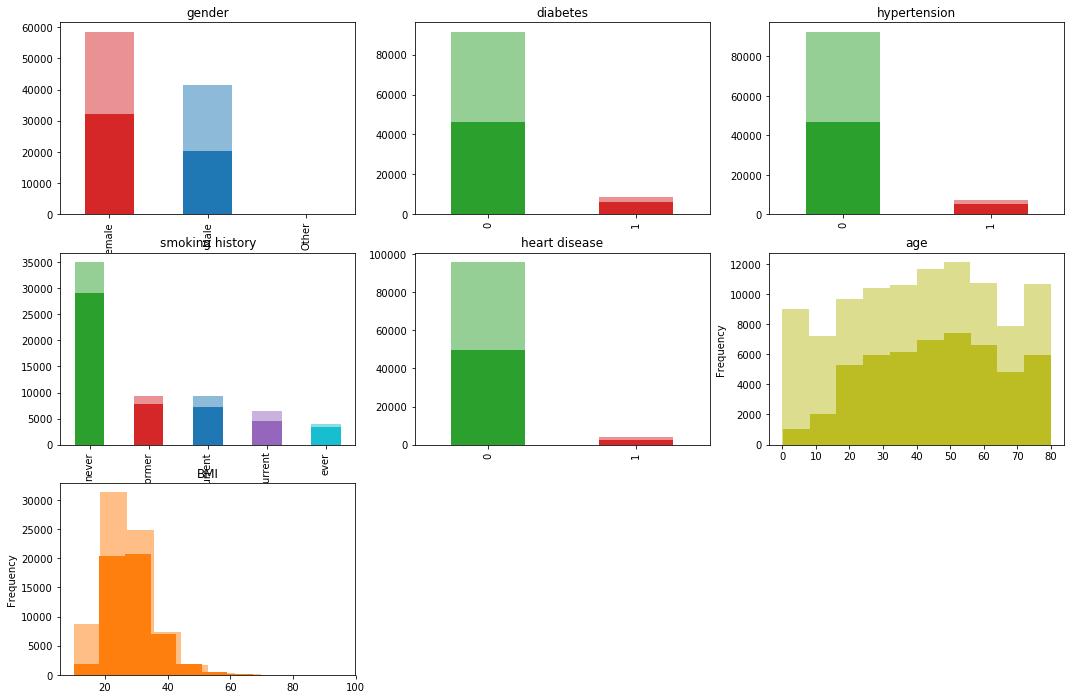

In [158]:
print('Data cleaning...')
entries_before = df_data_raw.shape[0]
df_data = df_data_raw.dropna(axis=0, how='any')
entries_after = df_data.shape[0]
dropped = entries_before - entries_after
print(f'{dropped} of {entries_before} lines dropped')

fig, axes = plt.subplots(nrows=3,ncols=3,figsize=(18,12))
df_data_raw['gender'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,0], alpha=0.5, title='gender')
df_data['gender'].value_counts().plot(kind='bar', color=['tab:red', 'tab:blue'],ax=axes[0,0], title='gender')

df_data_raw['diabetes'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'], ax=axes[0,1],alpha=0.5, title='diabetes')
df_data['diabetes'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'], ax=axes[0,1], title='diabetes')

df_data_raw['hypertension'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[0,2],alpha=0.5, title='hypertension')
df_data['hypertension'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[0,2], title='hypertension')

df_data_raw['smoking history'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:cyan'],ax=axes[1,0],alpha=0.5, title='smoking history')
df_data['smoking history'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red', 'tab:blue', 'tab:purple', 'tab:cyan'],ax=axes[1,0], title='smoking history')

df_data_raw['heart disease'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[1,1],alpha=0.5, title='heart disease')
df_data['heart disease'].value_counts().plot(kind='bar', color=['tab:green', 'tab:red'],ax=axes[1,1], title='heart disease')

df_data_raw['age'].plot(kind='hist',title='age', color='tab:olive',ax=axes[1,2], alpha=0.5)
df_data['age'].plot(kind='hist',title='age', color='tab:olive',ax=axes[1,2])

df_data_raw['BMI'].plot(kind='hist',title='BMI', color='tab:orange', ax=axes[2,0], alpha=0.5)
df_data['BMI'].plot(kind='hist',title='BMI', color='tab:orange', ax=axes[2,0])

fig.delaxes(axes[2][2])
fig.delaxes(axes[2][1])



## Data Wrangling

In [159]:
#rearrange df
df_data = df_data[['gender','age','diabetes','hypertension','stroke',
                   'smoking history','BMI', 'heart disease']]
#input variables X
X = df_data[['gender','age','diabetes','hypertension','stroke',
                   'smoking history','BMI']]
#output variable y
y = df_data['heart disease']

## Data Preparation

In [184]:
categorial = df_data[['gender', 'diabetes', 'hypertension', 'stroke', 'smoking history']].values

#onehotencode categorical data, i.e. every col except age and BMI

# TODO: maybe drop one hot encoding. Is one hot encoding necessary?
#one hot encode  categorical cols (see categorial) --> prep for xgboost
def onehotencode(categorial_data):
    encoded_X = None
    for i in range(0, categorial_data.shape[1]):
        label_encoder = LabelEncoder()
        feature = label_encoder.fit_transform(categorial_data[:,i])
        feature = feature.reshape(categorial_data.shape[0], 1)
        onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
        feature = onehot_encoder.fit_transform(feature)
        #add feature to encoded_X
        if encoded_X is None:
            encoded_X = feature
        else:
            encoded_X = np.concatenate((encoded_X, feature), axis=1)
    return encoded_X

encoded_X = onehotencode(categorial)


#add 'age','BMI'
numeric_cols = ['age', 'BMI']
for col in numeric_cols:
    values = X[col].values
    values = values.reshape(values.shape[0],1)
    encoded_X = np.concatenate((encoded_X, values), axis=1)
    
#reshape output variables
reshaped_y = y.values
reshaped_y = reshaped_y.reshape(y.shape[0],) 
     
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(encoded_X, reshaped_y, test_size = 0.3)

## Model

In [202]:
eval_set =[(X_train, y_train), (X_test, y_test)]

#fit model
model = XGBClassifier()
model.fit(X_train, y_train,early_stopping_rounds=10, eval_metric=['error', 'logloss'], eval_set=eval_set) 
#print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.050956	validation_0-logloss:0.61502	validation_1-error:0.047786	validation_1-logloss:0.614356
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.050956	validation_0-logloss:0.55088	validation_1-error:0.047786	validation_1-logloss:0.549927
[2]	validation_0-error:0.050956	validation_0-logloss:0.497749	validation_1-error:0.047786	validation_1-logloss:0.496177
[3]	validation_0-error:0.050956	validation_0-logloss:0.452951	validation_1-error:0.047786	validation_1-logloss:0.451091
[4]	validation_0-error:0.050956	validation_0-logloss:0.415007	validation_1-error:0.047786	validation_1-logloss:0.412645
[5]	validation_0-error:0.050956	validation_0-logloss:0.382451	validation_1-error:0.047786	validation_1-logloss:0.379821
[6]	validation_0-error:0.050956	validation_0-logloss:0.354451	validation_1-error:0.047786	validation_1-logloss:0.3515

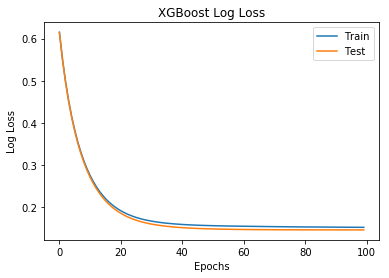

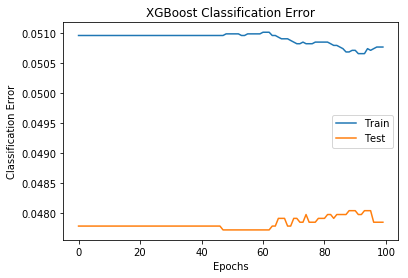

In [203]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.xlabel('Epochs')
plt.show()

## Feature Importance

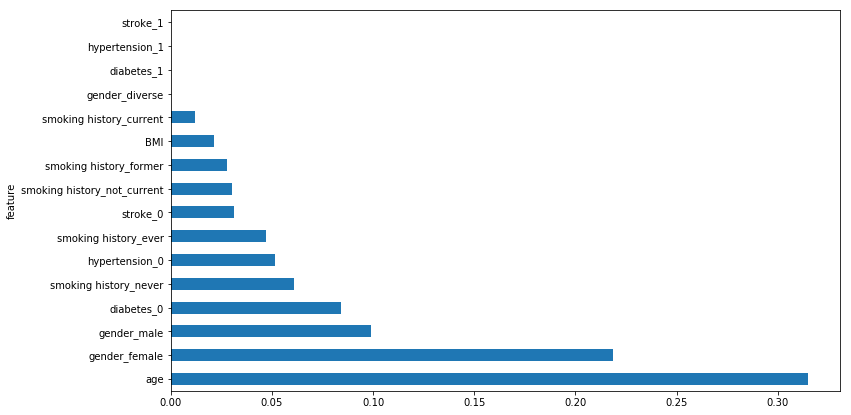

In [204]:
#encoded_X col labels:  
labels = ['gender_female', 'gender_male', 'gender_diverse', 'diabetes_0', 'diabetes_1',
        'hypertension_0','hypertension_1', 'stroke_0', 'stroke_1', 
        'smoking history_current', 'smoking history_ever', 'smoking history_former', 
        'smoking history_never', 'smoking history_not_current','age', 'BMI']  

df_enc = pd.DataFrame(encoded_X)
df_enc.columns = labels

def feature_imp(df,model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

feature_imp(df_enc ,model).plot('feature', 'importance', kind='barh', figsize=(12,7), legend=False)

## Predict whether or not you suffer from heart disease

In [214]:
# TODO: model always predicts zero, maybe choose Support Vector Machine? 
gender_female = 0 
gender_male = 1
gender_diverse = 0
diabetes_0 = 0  
diabetes_1 = 0
hypertension_0 = 0
hypertension_1 = 0
stroke_0 = 0
stroke_1 = 0
smoking_history_current = 1
smoking_history_ever = 0
smoking_history_former = 0
smoking_history_never = 0
smoking_history_not_current = 0


'''
gender = 'Female' #'Male', 'Female'
diabetes = 0      #O- no; 1- yes
hypertension = 0 #O- no; 1- yes
stroke = 0        #O- no; 1- yes
smoking_history = 'never' #'current', 'ever', 'former', 'never', 'not current'
'''

age = 80.0        #O- no; 1- yes
BMI =  130/1.65**2 # mass/height², Units: mass-->[kg], height--> [m]



predict = np.array([[gender_female, gender_male, gender_diverse,
                 diabetes_0, diabetes_1, 
                 hypertension_0, hypertension_1, 
                 stroke_0, stroke_1, 
                 smoking_history_current, smoking_history_ever, smoking_history_former, smoking_history_never, smoking_history_not_current,
                 age,
                 BMI]])

print(model.predict(predict)[0])


0


In [33]:
'''
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
'''

"\n#Import svm model\nfrom sklearn import svm\n\n#Create a svm Classifier\nclf = svm.SVC(kernel='linear') # Linear Kernel\n\n#Train the model using the training sets\nclf.fit(X_train, y_train)\n\n#Predict the response for test dataset\ny_pred = clf.predict(X_test)\n"

In [34]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

clf.predict(predict)[0]

Accuracy: 0.9497853419196566


NameError: name 'clf' is not defined

## Test basic neural network

In [195]:
# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense

input_dim = X_train.shape[1]

# create model
model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
fitted = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)
# evaluate the model
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Train on 36522 samples, validate on 15653 samples
Epoch 1/20
36522/36522 [==============================] - 2s 66us/step - loss: 0.1823 - acc: 0.9478 - val_loss: 0.1604 - val_acc: 0.9502
Epoch 2/20
36522/36522 [==============================] - 2s 53us/step - loss: 0.1657 - acc: 0.9491 - val_loss: 0.1507 - val_acc: 0.9522
Epoch 3/20
36522/36522 [==============================] - 2s 52us/step - loss: 0.1623 - acc: 0.9490 - val_loss: 0.1490 - val_acc: 0.9522
Epoch 4/20
36522/36522 [==============================] - 2s 53us/step - loss: 0.1606 - acc: 0.9489 - val_loss: 0.1475 - val_acc: 0.9523
Epoch 5/20
36522/36522 [==============================] - 2s 55us/step - loss: 0.1604 - acc: 0.9490 - val_loss: 0.1464 - val_acc: 0.9523
Epoch 6/20
36522/36522 [==============================] - 2s 58us/step - loss: 0.1594 - acc: 0.9491 - val_loss: 0.1473 - val_acc: 0.9522
Epoch 7/20
36522/36522 [==============================] - 2s 53us/step - loss: 0.1588 - acc: 0.9491 - val_loss: 0.1463 - val_acc

In [208]:
# calculate predictions
predictions = model.predict(predict)
# round predictions
rounded = [round(x[0]) for x in predictions]
print(rounded)

IndexError: invalid index to scalar variable.

In [187]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.949, Test: 0.952


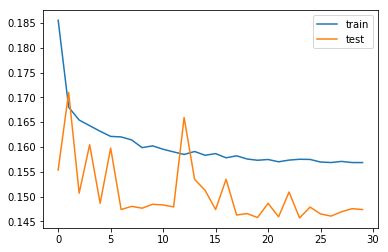

In [188]:
# plot training history
plt.plot(fitted.history['loss'], label='train')
plt.plot(fitted.history['val_loss'], label='test')
plt.legend()
plt.show()